In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random as rn

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from PIL import Image
%matplotlib inline
import time


# Tensorflow Libraries
from keras import models
import tensorflow as tf
from tensorflow.keras import applications as app
from tensorflow.keras.models import Sequential # Sequential model initialization
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data pipeline building
from functools import partial
import keras
from keras import backend as K
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')
# various library seeds

import warnings
warnings.filterwarnings('ignore')

C:\Users\ratch\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# 1. Create a dataframe with the Images and Label

In [20]:
# Set the path to the dataset
dataset = 'C:/Users/ratch/Desktop/Deep learning/Durian/Durian_dataset/'

def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [21]:
image_df

Filepath     Label
0     C:\Users\ratch\Desktop\Deep learning\Durian\Du...     chani
1     C:\Users\ratch\Desktop\Deep learning\Durian\Du...     chani
2     C:\Users\ratch\Desktop\Deep learning\Durian\Du...     chani
3     C:\Users\ratch\Desktop\Deep learning\Durian\Du...     chani
4     C:\Users\ratch\Desktop\Deep learning\Durian\Du...     chani
...                                                 ...       ...
1227  C:\Users\ratch\Desktop\Deep learning\Durian\Du...  Monthong
1228  C:\Users\ratch\Desktop\Deep learning\Durian\Du...  Monthong
1229  C:\Users\ratch\Desktop\Deep learning\Durian\Du...  Monthong
1230  C:\Users\ratch\Desktop\Deep learning\Durian\Du...    Kanyao
1231  C:\Users\ratch\Desktop\Deep learning\Durian\Du...    Kanyao

[1232 rows x 2 columns]

In [22]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

# 2. Exploratory data analysis (EDA)

In [23]:
class_types = len(os.listdir(dataset_path))
print('Number of classes for Classification: ',class_types)
class_names = os.listdir(dataset_path)
print(f'The class names are {class_names}\n')

print('Training dataset:')
for i in class_names:
    print(i + ':' + str(len(os.listdir(dataset_path+i))))

Number of classes for Classification:  4
The class names are ['chani', 'fruit', 'Kanyao', 'Monthong']

Training dataset:
chani:170
fruit:148
Kanyao:131
Monthong:171


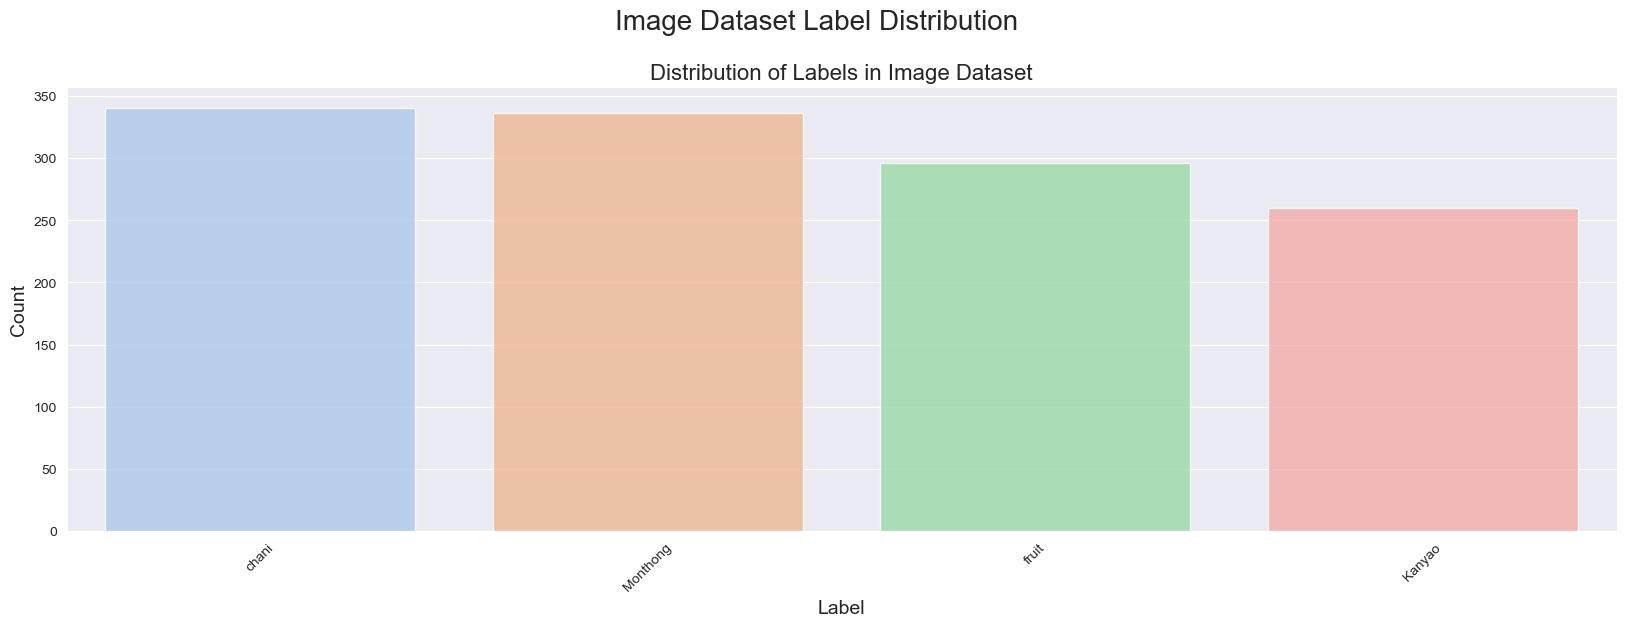

In [27]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

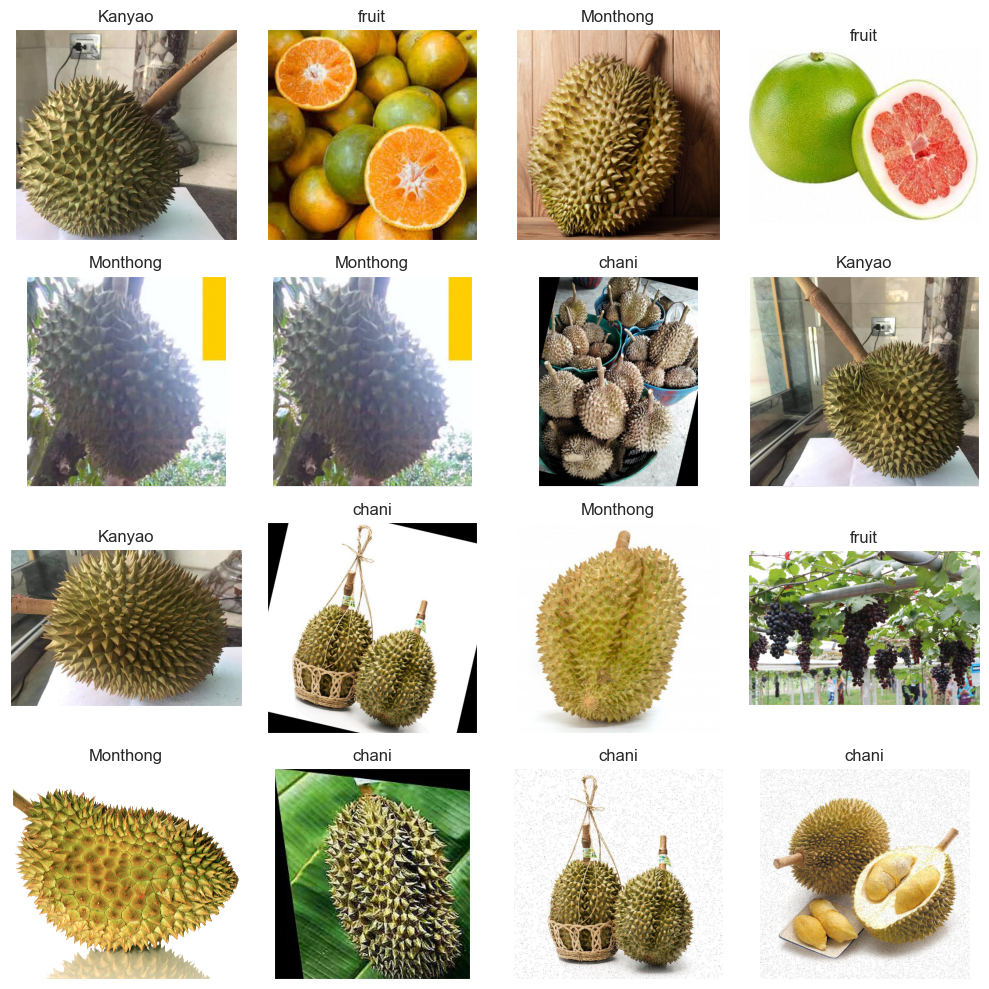

In [24]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 3.Data Preprocessing

In [31]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [28]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [29]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [41]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 788 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 247 validated image filenames belonging to 4 classes.


In [42]:
print(train_df.shape)

(985, 2)


In [44]:
print(test_df.shape)

(247, 2)


# 4.Training model

In [34]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 13s 0us/step


In [35]:
pretrained_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2a_activation (Activation  (None, 56, 56, 192)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2a_se_reshape[0][0]']     
          

                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 56, 56, 288)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2e_se_excite[0][0]']      
                                                                                                  
 block2e_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2e_drop (Dropout)         (None, 56, 56, 48)   0           ['block2e_project_bn[0][0]']     
                                                                                                  
 block2e_add (Add)              (None, 56, 56, 48)   0           ['block2e_drop[0][0]',           
                                                                  'block2d_add[0][0]']            
          

                                                                                                  
 block2g_drop (Dropout)         (None, 56, 56, 48)   0           ['block2g_project_bn[0][0]']     
                                                                                                  
 block2g_add (Add)              (None, 56, 56, 48)   0           ['block2g_drop[0][0]',           
                                                                  'block2f_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 56, 56, 288)  13824       ['block2g_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 56, 56, 288)  1152       ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 28, 28, 480)  1920       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_expand_activation (Act  (None, 28, 28, 480)  0          ['block3c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_b

 ivation)                                                                                         
                                                                                                  
 block3e_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3e_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3e_activation (Activation  (None, 28, 28, 480)  0          ['block3e_bn[0][0]']             
 )                                                                                                
          

 block3g_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3g_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3g_activation (Activation  (None, 28, 28, 480)  0          ['block3g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3g_se_squeeze (GlobalAver  (None, 480)         0           ['block3g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3g_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3g_se_squeeze[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
          

                                                                                                  
 block4d_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4f_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 14, 14, 160)  0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 14, 14, 160)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
          

                                                                                                  
 block4h_drop (Dropout)         (None, 14, 14, 160)  0           ['block4h_project_bn[0][0]']     
                                                                                                  
 block4h_add (Add)              (None, 14, 14, 160)  0           ['block4h_drop[0][0]',           
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4j_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 14, 14, 960)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5a_expand_activation[0][0]
 D)       

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 1344  33600      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5c_activation (Activation  (None, 14, 14, 1344  0          ['block5c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5c_s

                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5e_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 1344  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_s

                                                                                                  
 block5g_activation (Activation  (None, 14, 14, 1344  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
          

                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_s

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 384)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 384)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 384)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6j_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6j_dwconv[0][0]']         
 )        

                                                                                                  
 block6l_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6l_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6l_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 7, 7, 2304)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 2304)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_s

 block7c_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7c_se_reshape[0][0]']     
                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7c_activation[0][0]',     
                                                                  'block7c_se_expand[0][0]']      
                                                                                                  
 block7c_project_conv (Conv2D)  (None, 7, 7, 640)    2457600     ['block7c_se_excite[0][0]']      
                                                                                                  
 block7c_project_bn (BatchNorma  (None, 7, 7, 640)   2560        ['block7c_project_conv[0][0]']   
 lization)

In [37]:
tf.keras.utils.plot_model(pretrained_model, to_file = 'InceptionV3_Model.png', show_shapes = True, show_dtype = False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:
#Iterate over all layers in the model
for i, layer in enumerate(pretrained_model.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = rescaling, Trainable = False
Layer 2: Name = normalization, Trainable = False
Layer 3: Name = rescaling_1, Trainable = False
Layer 4: Name = stem_conv_pad, Trainable = False
Layer 5: Name = stem_conv, Trainable = False
Layer 6: Name = stem_bn, Trainable = False
Layer 7: Name = stem_activation, Trainable = False
Layer 8: Name = block1a_dwconv, Trainable = False
Layer 9: Name = block1a_bn, Trainable = False
Layer 10: Name = block1a_activation, Trainable = False
Layer 11: Name = block1a_se_squeeze, Trainable = False
Layer 12: Name = block1a_se_reshape, Trainable = False
Layer 13: Name = block1a_se_reduce, Trainable = False
Layer 14: Name = block1a_se_expand, Trainable = False
Layer 15: Name = block1a_se_excite, Trainable = False
Layer 16: Name = block1a_project_conv, Trainable = False
Layer 17: Name = block1a_project_bn, Trainable = False
Layer 18: Name = block1b_dwconv, Trainable = False
Layer 19: Name = block1b_bn, Trainable = F

In [51]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

In [59]:

inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

 block1c_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 112, 112, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2a_activation (Activation  (None, 56, 56, 192)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2a_se_reshape[0][0]']     
          

                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 56, 56, 288)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, 56, 56, 48)   13824       ['block2e_se_excite[0][0]']      
                                                                                                  
 block2e_project_bn (BatchNorma  (None, 56, 56, 48)  192         ['block2e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2e_drop (Dropout)         (None, 56, 56, 48)   0           ['block2e_project_bn[0][0]']     
                                                                                                  
 block2e_add (Add)              (None, 56, 56, 48)   0           ['block2e_drop[0][0]',           
                                                                  'block2d_add[0][0]']            
          

                                                                                                  
 block2g_drop (Dropout)         (None, 56, 56, 48)   0           ['block2g_project_bn[0][0]']     
                                                                                                  
 block2g_add (Add)              (None, 56, 56, 48)   0           ['block2g_drop[0][0]',           
                                                                  'block2f_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 56, 56, 288)  13824       ['block2g_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 56, 56, 288)  1152       ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 28, 28, 480)  1920       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_expand_activation (Act  (None, 28, 28, 480)  0          ['block3c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_b

 ivation)                                                                                         
                                                                                                  
 block3e_dwconv (DepthwiseConv2  (None, 28, 28, 480)  12000      ['block3e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3e_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3e_activation (Activation  (None, 28, 28, 480)  0          ['block3e_bn[0][0]']             
 )                                                                                                
          

 block3g_bn (BatchNormalization  (None, 28, 28, 480)  1920       ['block3g_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3g_activation (Activation  (None, 28, 28, 480)  0          ['block3g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3g_se_squeeze (GlobalAver  (None, 480)         0           ['block3g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3g_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3g_se_squeeze[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
          

                                                                                                  
 block4d_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4f_project_conv (Conv2D)  (None, 14, 14, 160)  153600      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 14, 14, 160)  640        ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 14, 14, 160)  0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 14, 14, 160)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
          

                                                                                                  
 block4h_drop (Dropout)         (None, 14, 14, 160)  0           ['block4h_project_bn[0][0]']     
                                                                                                  
 block4h_add (Add)              (None, 14, 14, 160)  0           ['block4h_drop[0][0]',           
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 960)  153600      ['block4j_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 960)  3840       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 14, 14, 960)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5a_expand_activation[0][0]
 D)       

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 1344  33600      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5c_activation (Activation  (None, 14, 14, 1344  0          ['block5c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5c_s

                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 1344  5376       ['block5e_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 1344  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_s

                                                                                                  
 block5g_activation (Activation  (None, 14, 14, 1344  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
          

                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_s

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 7, 7, 2304)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 384)    884736      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 7, 7, 384)   1536        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 384)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 384)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 7, 7, 384)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 2304)   884736      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 7, 7, 2304)  9216        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 7, 7, 2304)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6j_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6j_dwconv[0][0]']         
 )        

                                                                                                  
 block6l_dwconv (DepthwiseConv2  (None, 7, 7, 2304)  57600       ['block6l_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 7, 7, 2304)  9216        ['block6l_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 7, 7, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 7, 7, 2304)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 2304)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_s

 block7c_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7c_se_reshape[0][0]']     
                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 7, 7, 3840)   0           ['block7c_activation[0][0]',     
                                                                  'block7c_se_expand[0][0]']      
                                                                                                  
 block7c_project_conv (Conv2D)  (None, 7, 7, 640)    2457600     ['block7c_se_excite[0][0]']      
                                                                                                  
 block7c_project_bn (BatchNorma  (None, 7, 7, 640)   2560        ['block7c_project_conv[0][0]']   
 lization)

In [60]:
''' Model Compilation '''
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [61]:
checkpoint_filepath = "bestweights.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

In [62]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
25/25 [==============================] - 30s 668ms/step - loss: 1.3263 - acc: 0.5127 - val_loss: 3.1250 - val_acc: 0.4975
Epoch 2/100
25/25 [==============================] - 13s 490ms/step - loss: 0.8425 - acc: 0.6954 - val_loss: 0.8238 - val_acc: 0.6345
Epoch 3/100
25/25 [==============================] - 13s 514ms/step - loss: 0.6274 - acc: 0.7449 - val_loss: 0.3845 - val_acc: 0.8680
Epoch 4/100
25/25 [==============================] - 12s 483ms/step - loss: 0.5660 - acc: 0.7830 - val_loss: 0.4205 - val_acc: 0.8325
Epoch 5/100
25/25 [==============================] - 12s 467ms/step - loss: 0.4254 - acc: 0.8414 - val_loss: 0.4553 - val_acc: 0.8020
Epoch 6/100
25/25 [==============================] - 13s 515ms/step - loss: 0.3720 - acc: 0.8642 - val_loss: 0.2921 - val_acc: 0.9239
Epoch 7/100
25/25 [==============================] - 12s 475ms/step - loss: 0.3782 - acc: 0.8591 - val_loss: 0.4056 - val_acc: 0.8223
Epoch 8/100
25/25 [==============================] - 12s 477ms

Epoch 62/100
25/25 [==============================] - 13s 500ms/step - loss: 0.1761 - acc: 0.9327 - val_loss: 0.2773 - val_acc: 0.8934
Epoch 63/100
25/25 [==============================] - 13s 493ms/step - loss: 0.1451 - acc: 0.9365 - val_loss: 0.5515 - val_acc: 0.8426
Epoch 64/100
25/25 [==============================] - 13s 486ms/step - loss: 0.1897 - acc: 0.9226 - val_loss: 0.2689 - val_acc: 0.8883
Epoch 65/100
25/25 [==============================] - 13s 516ms/step - loss: 0.1598 - acc: 0.9365 - val_loss: 0.1006 - val_acc: 0.9746
Epoch 66/100
25/25 [==============================] - 13s 485ms/step - loss: 0.1354 - acc: 0.9505 - val_loss: 0.2164 - val_acc: 0.9289
Epoch 67/100
25/25 [==============================] - 12s 493ms/step - loss: 0.1134 - acc: 0.9645 - val_loss: 0.1480 - val_acc: 0.9543
Epoch 68/100
25/25 [==============================] - 13s 521ms/step - loss: 0.1321 - acc: 0.9492 - val_loss: 0.1337 - val_acc: 0.9543
Epoch 69/100
25/25 [==============================] - 1

In [63]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.17726
Test Accuracy: 95.55%


# 5. Visualizing loss curves

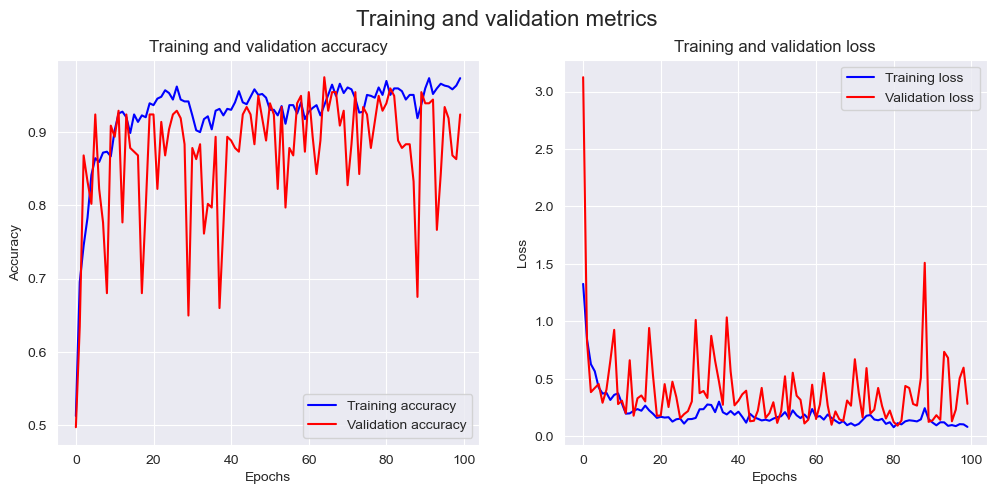

In [66]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [68]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

8/8 [==============================] - 3s 376ms/step
The first 4 predictions: ['Monthong', 'Kanyao', 'fruit', 'Monthong']


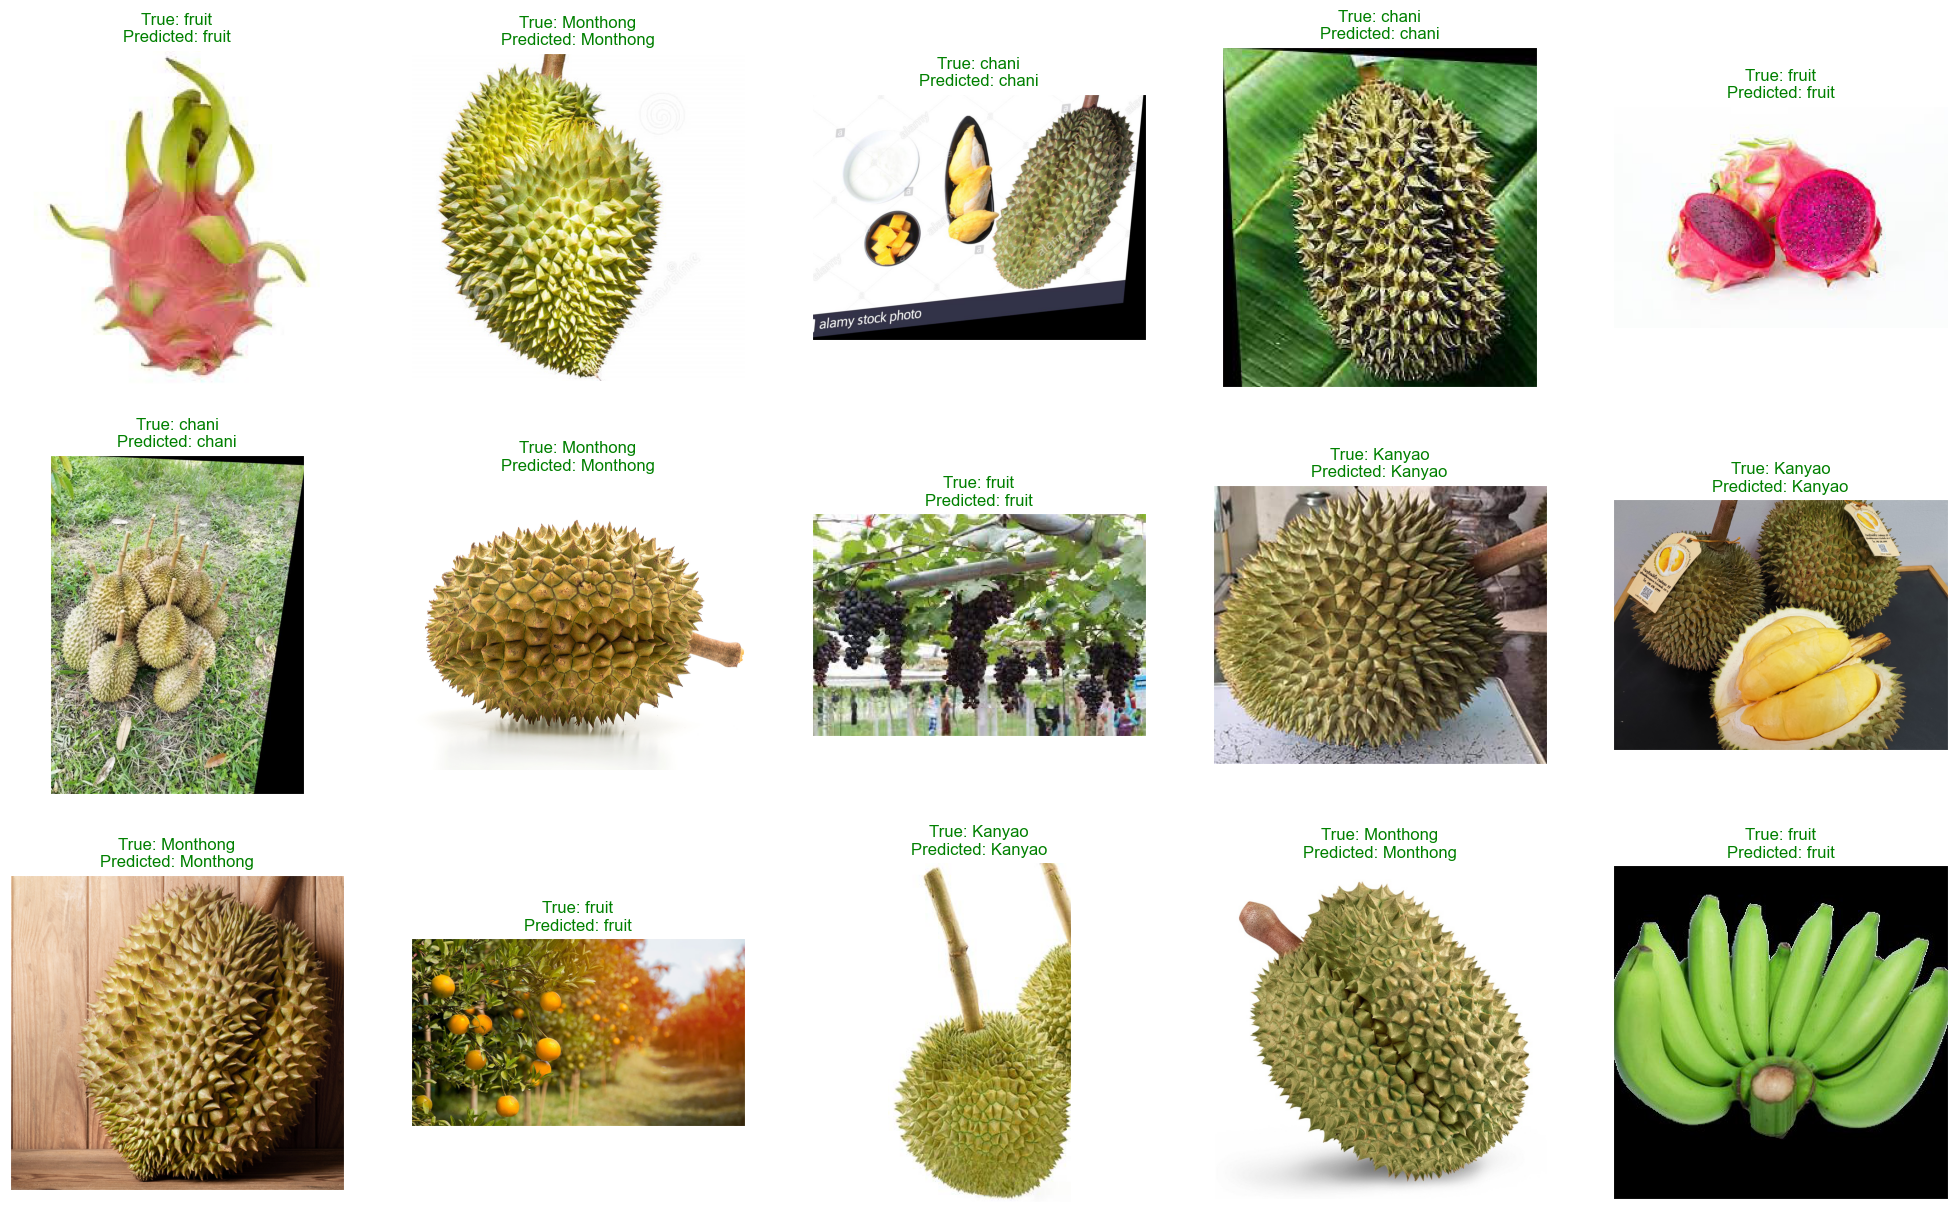

<Figure size 640x480 with 0 Axes>

In [69]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 6. Plotting the Classification Reports and Confusion Matrix

In [71]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Kanyao       1.00      0.80      0.89        55
    Monthong       0.88      1.00      0.94        60
       chani       0.96      1.00      0.98        71
       fruit       1.00      1.00      1.00        61

    accuracy                           0.96       247
   macro avg       0.96      0.95      0.95       247
weighted avg       0.96      0.96      0.95       247



In [72]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Kanyao         1.000000  0.800000  0.888889   55.000000
Monthong       0.882353  1.000000  0.937500   60.000000
chani          0.959459  1.000000  0.979310   71.000000
fruit          1.000000  1.000000  1.000000   61.000000
accuracy       0.955466  0.955466  0.955466    0.955466
macro avg      0.960453  0.950000  0.951425  247.000000
weighted avg   0.959768  0.955466  0.954129  247.000000

In [74]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

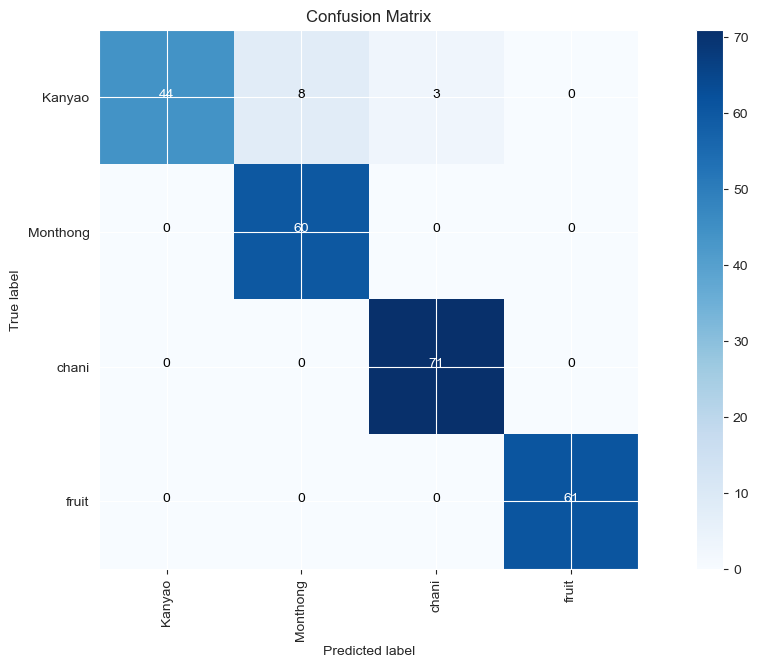

In [75]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# 7.Grad-Cam Visualization

#### Grad-CAM (Gradient-weighted Class Activation Mapping) คือเทคนิคที่ใช้ในการแสดงภาพภูมิภาคของภาพอินพุตที่มีความสำคัญที่สุดต่อการทำนายของเครือข่ายประสาทเทียม ช่วยให้คุณเห็นว่าภูมิภาคใดของภาพที่โมเดลให้ความสำคัญขณะทำการทำนาย Grad-CAM เป็นการปรับปรุงเทคนิค CAM ซึ่งขยายไปสู่โมเดลใดๆ ที่ใช้เครือข่ายประสาท convolutional (CNN) เป็นสถาปัตยกรรมพื้นฐาน

In [76]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

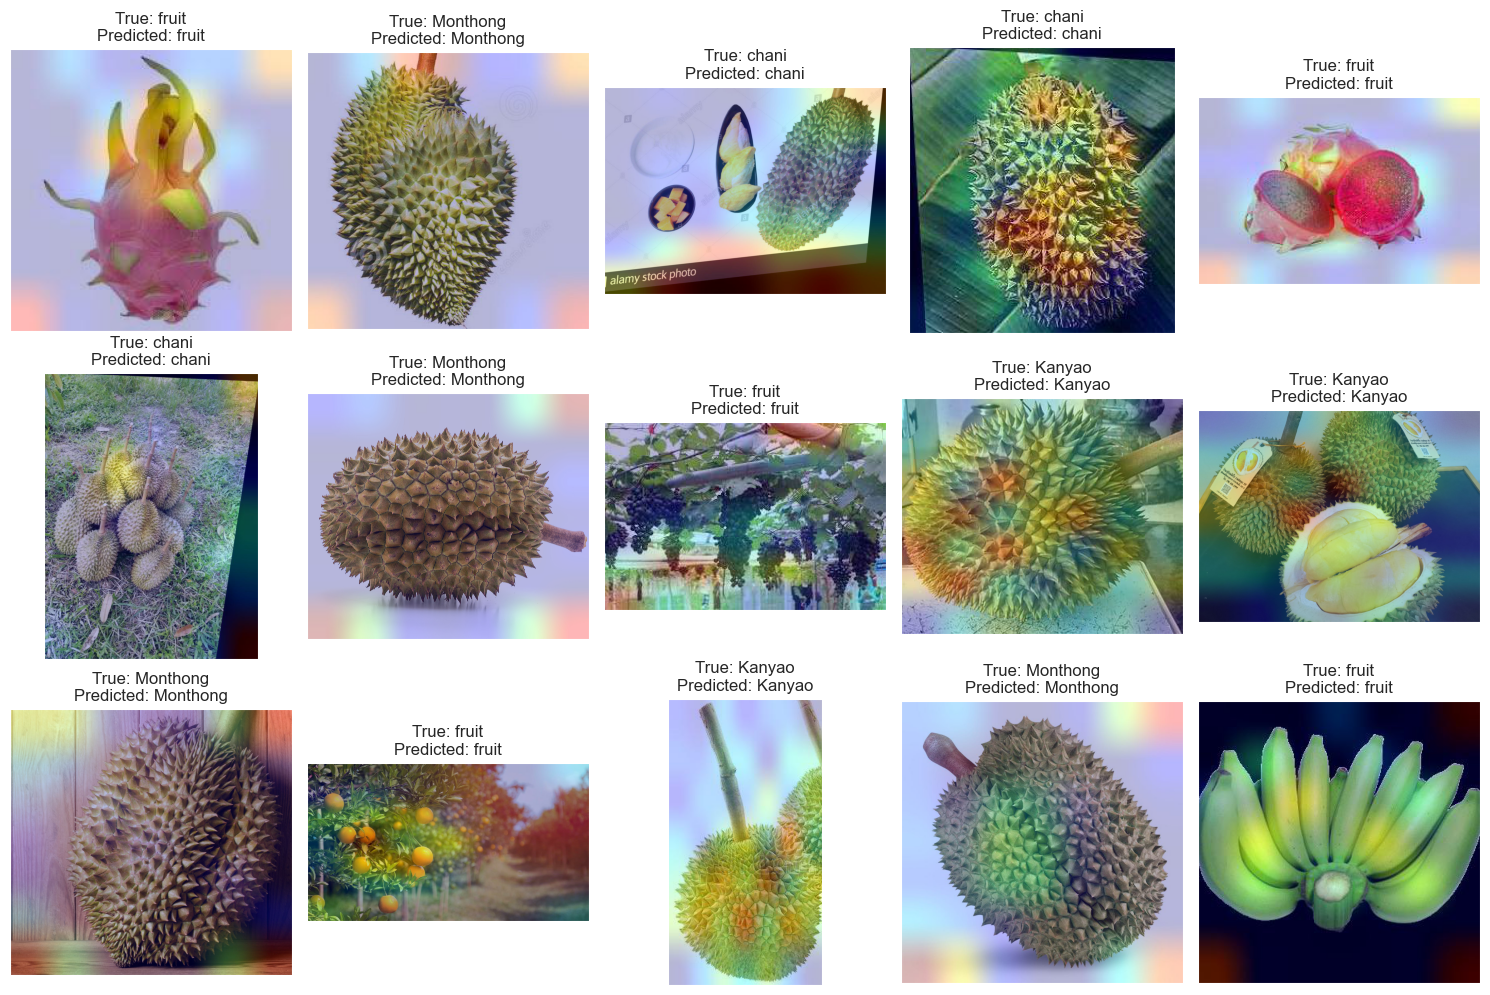

In [77]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()